# Thermal Emotion Recognition Data Pipeline
This notebook demonstrates how to load, preprocess, augment, and split thermal images by emotion and palette for model training.

## 1. Import Required Libraries
We will use TensorFlow, scikit-learn, OpenCV, numpy, and matplotlib for data processing and visualization.

In [25]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Load and Explore Dataset
Let's count images per emotion and palette to understand our dataset distribution.

In [26]:
from collections import defaultdict

DATASET_DIR = r"d:/R&I/Facial emotion"
counts = defaultdict(lambda: defaultdict(int))

for emotion in os.listdir(DATASET_DIR):
    emotion_path = os.path.join(DATASET_DIR, emotion)
    if not os.path.isdir(emotion_path):
        continue
    for palette in os.listdir(emotion_path):
        palette_path = os.path.join(emotion_path, palette)
        if not os.path.isdir(palette_path):
            continue
        image_files = [f for f in os.listdir(palette_path) if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
        counts[emotion][palette] = len(image_files)

for emotion, palettes in counts.items():
    print(f"Emotion: {emotion}")
    for palette, count in palettes.items():
        print(f"  Palette: {palette} - {count} images")
    print()

Emotion: angry
  Palette: ICEBLUE - 110 images
  Palette: IRNBOW - 98 images
  Palette: RAINBOW - 100 images
  Palette: Red Hot - 100 images
  Palette: White Hot - 101 images

Emotion: happy
  Palette: ICEBLUE - 106 images
  Palette: IRON - 104 images
  Palette: RAINBOW - 118 images
  Palette: Red Hot - 101 images
  Palette: White Hot - 109 images

Emotion: natural
  Palette: ICEBLUE - 105 images
  Palette: IRON - 92 images
  Palette: RAINBOW - 119 images
  Palette: Red Hot - 110 images
  Palette: White Hot - 115 images

Emotion: sad
  Palette: ICEBLUE - 82 images
  Palette: IRON - 90 images
  Palette: RAINBOW - 93 images
  Palette: Red Hot - 93 images
  Palette: White Hot - 99 images

Emotion: surpise
  Palette: ICEBLUE - 82 images
  Palette: IRON - 90 images
  Palette: RAINBOW - 91 images
  Palette: Red Hot - 86 images
  Palette: White Hot - 91 images



## 3. Prepare Image Paths and Labels
We will collect image file paths and encode emotion and palette labels for model training.

In [27]:
image_paths = []
emotion_labels = []
palette_labels = []
for emotion in os.listdir(DATASET_DIR):
    emotion_path = os.path.join(DATASET_DIR, emotion)
    if not os.path.isdir(emotion_path):
        continue
    for palette in os.listdir(emotion_path):
        palette_path = os.path.join(emotion_path, palette)
        if not os.path.isdir(palette_path):
            continue
        for fname in os.listdir(palette_path):
            if fname.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(palette_path, fname))
                emotion_labels.append(emotion)
                palette_labels.append(palette)

print(f"Total images: {len(image_paths)}")

Total images: 2485


## 4. Encode Labels and Split Data
We will encode the emotion and palette labels, then split the data into training and validation sets.

In [28]:
emotion_encoder = LabelEncoder()
palette_encoder = LabelEncoder()
emotion_labels_encoded = emotion_encoder.fit_transform(emotion_labels)
palette_labels_encoded = palette_encoder.fit_transform(palette_labels)

train_idx, val_idx = train_test_split(
    np.arange(len(image_paths)), test_size=0.2, stratify=emotion_labels_encoded, random_state=42
)

train_paths = [image_paths[i] for i in train_idx]
train_emotions = [emotion_labels_encoded[i] for i in train_idx]
train_palettes = [palette_labels_encoded[i] for i in train_idx]

val_paths = [image_paths[i] for i in val_idx]
val_emotions = [emotion_labels_encoded[i] for i in val_idx]
val_palettes = [palette_labels_encoded[i] for i in val_idx]

print(f"Train images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Emotion classes: {emotion_encoder.classes_}")
print(f"Palette classes: {palette_encoder.classes_}")

Train images: 1988
Validation images: 497
Emotion classes: ['angry' 'happy' 'natural' 'sad' 'surpise']
Palette classes: ['ICEBLUE' 'IRNBOW' 'IRON' 'RAINBOW' 'Red Hot' 'White Hot']


## 5. Data Augmentation and Generator Setup
We will use Keras ImageDataGenerator to augment training images and prepare batches for model training.

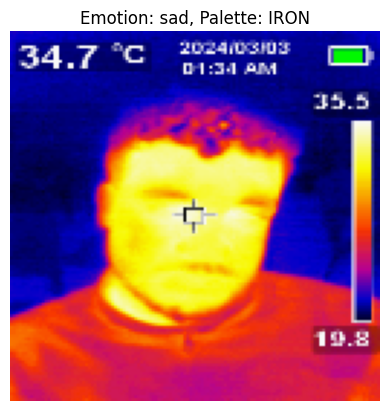

In [29]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Example: Load and show one image
img = cv2.imread(train_paths[0])
img = cv2.resize(img, IMG_SIZE)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(f"Emotion: {emotion_encoder.inverse_transform([train_emotions[0]])[0]}, Palette: {palette_encoder.inverse_transform([train_palettes[0]])[0]}")
plt.axis('off')
plt.show()

In [30]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Path to dataset
DATASET_DIR = r"d:\R&I\Facial emotion"
IMG_SIZE = (128, 128)  # You can adjust this size
BATCH_SIZE = 32

# Prepare lists for images and labels
def get_image_paths_and_labels(dataset_dir):
    image_paths = []
    emotion_labels = []
    palette_labels = []
    for emotion in os.listdir(dataset_dir):
        emotion_path = os.path.join(dataset_dir, emotion)
        if not os.path.isdir(emotion_path):
            continue
        for palette in os.listdir(emotion_path):
            palette_path = os.path.join(emotion_path, palette)
            if not os.path.isdir(palette_path):
                continue
            for fname in os.listdir(palette_path):
                if fname.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(palette_path, fname))
                    emotion_labels.append(emotion)
                    palette_labels.append(palette)
    return image_paths, emotion_labels, palette_labels

image_paths, emotion_labels, palette_labels = get_image_paths_and_labels(DATASET_DIR)

# Encode labels
from sklearn.preprocessing import LabelEncoder
emotion_encoder = LabelEncoder()
palette_encoder = LabelEncoder()
emotion_labels_encoded = emotion_encoder.fit_transform(emotion_labels)
palette_labels_encoded = palette_encoder.fit_transform(palette_labels)

# Split into train/val
train_idx, val_idx = train_test_split(
    np.arange(len(image_paths)), test_size=0.2, stratify=emotion_labels_encoded, random_state=42
)

train_paths = [image_paths[i] for i in train_idx]
train_emotions = [emotion_labels_encoded[i] for i in train_idx]
train_palettes = [palette_labels_encoded[i] for i in train_idx]

val_paths = [image_paths[i] for i in val_idx]
val_emotions = [emotion_labels_encoded[i] for i in val_idx]
val_palettes = [palette_labels_encoded[i] for i in val_idx]

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Helper function to generate batches
def data_generator(paths, emotions, palettes, datagen):
    while True:
        idxs = np.random.permutation(len(paths))
        for i in range(0, len(paths), BATCH_SIZE):
            batch_idxs = idxs[i:i+BATCH_SIZE]
            batch_images = []
            batch_emotions = []
            batch_palettes = []
            for j in batch_idxs:
                img = datagen.flow_from_directory(
                    os.path.dirname(paths[j]),
                    target_size=IMG_SIZE,
                    batch_size=1,
                    class_mode=None,
                    shuffle=False
                ).next()[0]
                batch_images.append(img)
                batch_emotions.append(emotions[j])
                batch_palettes.append(palettes[j])
            yield np.array(batch_images), np.array(batch_emotions), np.array(batch_palettes)

# Example usage:
# train_gen = data_generator(train_paths, train_emotions, train_palettes, train_datagen)
# val_gen = data_generator(val_paths, val_emotions, val_palettes, val_datagen)

print(f"Total images: {len(image_paths)}")
print(f"Train images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")
print(f"Emotion classes: {emotion_encoder.classes_}")
print(f"Palette classes: {palette_encoder.classes_}")

Total images: 2485
Train images: 1988
Validation images: 497
Emotion classes: ['angry' 'happy' 'natural' 'sad' 'surpise']
Palette classes: ['ICEBLUE' 'IRNBOW' 'IRON' 'RAINBOW' 'Red Hot' 'White Hot']


## 6. Build and Compile CNN Model
Let's define a simple CNN architecture for emotion classification.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

num_emotions = len(emotion_encoder.classes_)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_emotions, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

d:\R&I\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 7. Train the CNN Model
Now let's train the model using our data generators.

In [32]:
EPOCHS = 20

# Simple generator for training and validation
train_gen = (np.array([cv2.resize(cv2.imread(p), IMG_SIZE) for p in train_paths]) / 255.0, np.array(train_emotions))
val_gen = (np.array([cv2.resize(cv2.imread(p), IMG_SIZE) for p in val_paths]) / 255.0, np.array(val_emotions))

history = model.fit(
    train_gen[0], train_gen[1],
    validation_data=val_gen,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.1972 - loss: 1.6522 - val_accuracy: 0.2213 - val_loss: 1.6057
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.2299 - loss: 1.6046 - val_accuracy: 0.2274 - val_loss: 1.6006
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.2731 - loss: 1.5654 - val_accuracy: 0.3461 - val_loss: 1.4583
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.4034 - loss: 1.2949 - val_accuracy: 0.4628 - val_loss: 1.1716
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.5166 - loss: 1.0449 - val_accuracy: 0.6016 - val_loss: 0.8795
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.5900 - loss: 0.8717 - val_accuracy: 0.6378 - val_loss: 0.7935
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6449 - loss: 0.7480 - val_accuracy: 0.6378 - val_loss: 0.7074
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.7103 - loss: 0.6459 - val_accuracy: 0.7465 - v

## 8. Visualize Training Performance
Let's plot the training and validation accuracy and loss curves.

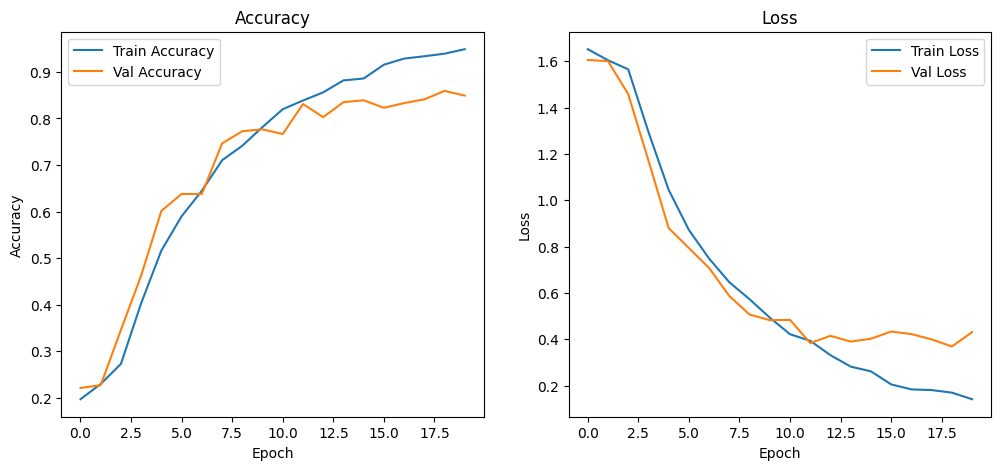

In [33]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 9. Evaluate Model and Show Predictions
Let's evaluate the model and display some predictions on validation images.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
              precision    recall  f1-score   support

       angry       0.85      0.86      0.86       102
       happy       0.88      0.91      0.89       108
     natural       0.91      0.97      0.94       108
         sad       0.77      0.74      0.75        91
     surpise       0.79      0.73      0.76        88

    accuracy                           0.85       497
   macro avg       0.84      0.84      0.84       497
weighted avg       0.85      0.85      0.85       497

Confusion Matrix:
[[ 88   8   5   0   1]
 [  7  98   3   0   0]
 [  1   1 105   1   0]
 [  4   3   1  67  16]
 [  3   1   1  19  64]]


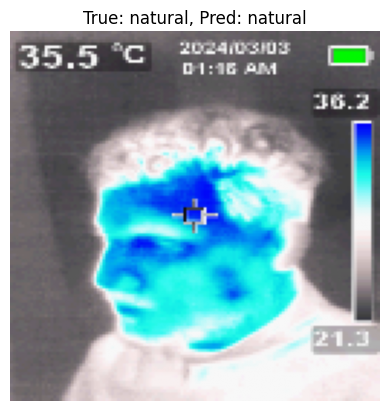

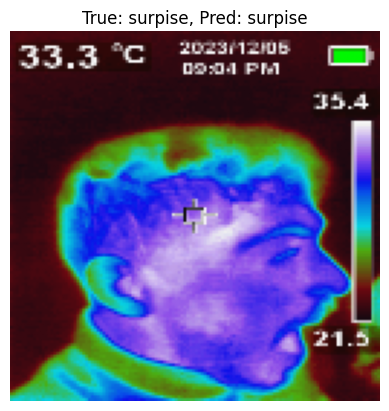

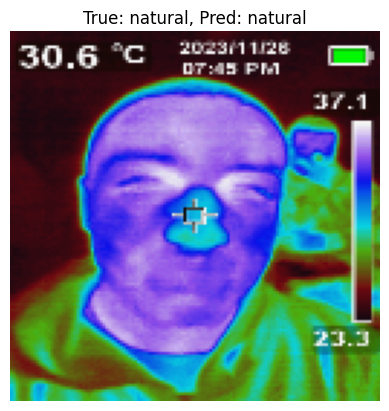

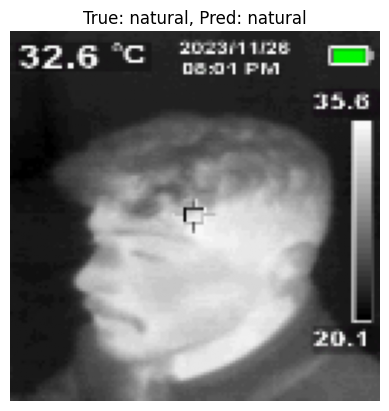

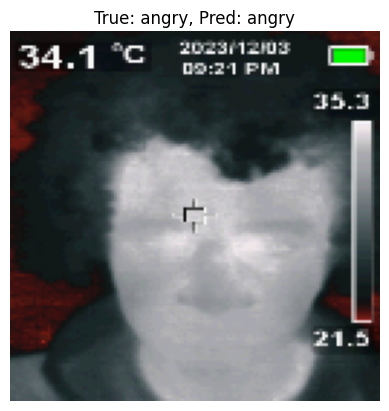

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

val_preds = np.argmax(model.predict(val_gen[0]), axis=1)
print(classification_report(val_gen[1], val_preds, target_names=emotion_encoder.classes_))
print('Confusion Matrix:')
print(confusion_matrix(val_gen[1], val_preds))

# Show a few predictions
for i in range(5):
    plt.imshow(val_gen[0][i])
    true_label = emotion_encoder.inverse_transform([val_gen[1][i]])[0]
    pred_label = emotion_encoder.inverse_transform([val_preds[i]])[0]
    plt.title(f'True: {true_label}, Pred: {pred_label}')
    plt.axis('off')
    plt.show()

## 11. Save Model for Later Use
Export the trained model to a file for use in a standalone Python script.

In [35]:
# Save the trained model as an HDF5 file
model.save('thermal_emotion_model.h5')
print('Model saved as thermal_emotion_model.h5')

Model saved as thermal_emotion_model.h5


## 12. Detailed Model Metrics: Accuracy, F1, ROC AUC
Let's calculate accuracy, F1-score, and ROC AUC for the validation set.

In [36]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Accuracy
acc = accuracy_score(val_gen[1], val_preds)
print(f'Validation Accuracy: {acc:.4f}')

# F1 Score (macro and weighted)
f1_macro = f1_score(val_gen[1], val_preds, average='macro')
f1_weighted = f1_score(val_gen[1], val_preds, average='weighted')
print(f'F1 Score (Macro): {f1_macro:.4f}')
print(f'F1 Score (Weighted): {f1_weighted:.4f}')

# ROC AUC (One-vs-Rest, macro)
from sklearn.preprocessing import label_binarize
val_true_bin = label_binarize(val_gen[1], classes=np.arange(len(emotion_encoder.classes_)))
val_pred_prob = model.predict(val_gen[0])
roc_auc = roc_auc_score(val_true_bin, val_pred_prob, average='macro', multi_class='ovr')
print(f'ROC AUC (Macro, OvR): {roc_auc:.4f}')

Validation Accuracy: 0.8491
F1 Score (Macro): 0.8411
F1 Score (Weighted): 0.8473
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
ROC AUC (Macro, OvR): 0.9780
